# **Fase exploratória**

In [16]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

### Atribuindo os dados

In [ ]:
df_agg_cod = pd.read_excel(
    '../../datasets/base_vertical/train/train_binario.xlsx')

df_agg_cod_norm = pd.read_excel(
    '../../datasets/base_vertical/train/train_binario_normalized.xlsx')

In [18]:
df_agg_cod.columns

Index(['window_id', 'freq_mean', 'centro_x_mean', 'centro_y_mean',
       'raio_medio_mean', 'raio_std_mean', 'raio_max_mean', 'raio_min_mean',
       'simetria_x_mean', 'simetria_y_mean', 'densidade_nucleo_mean',
       'comprimento_curva_mean', 'variacao_curvatura_mean',
       'mudanca_media_direcao_mean', 'entropia_raio_mean',
       'auto_intersecoes_mean', 'mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'rqa_recurrence_rate_mean',
       'rqa_determinism_mean', 'rqa_average_diagonal_line_mean',
       'rqa_longest_diagonal_line_mean', 'rqa_entropy_diagonal_lines_mean',
       'rqa_laminarity_mean', 'rqa_trapping_time_mean',
       'rqa_longest_vertical_line_mean', 'rqa_entropy_vertical_lines_mean',
       'rqa_fs_mean', 'rqa_embedding_dim_mean', 'rqa_delay_mean',
       'rqa_rqa_threshold_mean', 'rms_energy_mean

## 1. Describe Variables

Calcular estatísticas descritivas básicas (`count`, `mean`, `std`, `min`, `25%`, `50%`, `75%`, `max`) para todas as colunas numéricas.

"Quais variáveis mais variam entre as janelas?"

In [19]:
desc = df_agg_cod.describe().T.sort_values("std", ascending=False)
desc

,count,mean,std,min,25%,50%,75%,max
auto_intersecoes_mean,800.0,78735.410290,1.037145e+05,3591.981481,25342.241592,51089.625490,91548.804290,1.078025e+06
auto_intersecoes_std,800.0,709.168520,7.509117e+02,55.002336,232.307860,352.884309,800.150173,3.572562e+03
mfcc_0_mean,800.0,-104.804980,5.765263e+01,-326.816616,-131.120448,-98.522406,-65.564884,2.011215e+00
comprimento_curva_mean,800.0,92.793803,4.193400e+01,6.669564,63.724397,88.055380,112.783051,2.567962e+02
freq_mean,800.0,88.400935,4.122210e+01,37.388393,60.128811,72.780636,104.332876,2.440208e+02
...,...,...,...,...,...,...,...,...
rqa_rqa_threshold_mean,800.0,0.100000,3.466681e-16,0.100000,0.100000,0.100000,0.100000,1.000000e-01
rqa_embedding_dim_mean,800.0,5.000000,0.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000e+00
rqa_fs_mean,800.0,800.000000,0.000000e+00,800.000000,800.000000,800.000000,800.000000,8.000000e+02
rqa_delay_mean,800.0,2.000000,0.000000e+00,2.000000,2.000000,2.000000,2.000000,2.000000e+00


Variáveis com maior variabilidade (alto desvio padrão (`std`))

| Variável                 | Interpretação                                                                         |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `auto_intersecoes_mean`  | Varia muito de janela pra janela → sinal de **alta complexidade geométrica**          |
| `mfcc_0_mean`            | É a energia espectral global (1º coef. cepstral) → **bom sinal** que ele varia        |
| `comprimento_curva_mean` | Relacionado a densidade da winding → diferencia sons mais “longos” ou “curtos”        |
| `freq_mean`              | Frequência dominante média da janela → variação natural esperada em sons fisiológicos |

Ou seja, essas são as _features_  mais "vivas" do nosso dataset, as que provavelmente poderão ajudar os modelos a distinguir entre as classes.

Enquanto isso, as _features_ com menos variabilidade (desvio padrão (`std=0`)) são 

| Variável                 | Interpretação                                                                         |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `rqa_fs_mean	`           | Pois tem o valor fixo de 800. Taxa de amostragem usada no RQA, é esperada como constante         |
| `rqa_delay_mean`         | Valor fixo  =  2. Delay usado no embedding, fixado como hiperparâmetro, normal       |
| `rqa_embedding_dim_mean` | Dimensão do embedding, também fixada no código, esperado        |
| `rms_energy_std`         | Porque a energia já foi calculada uma única vez por janela.|

Ou seja, nenhuma dessas colunas com variabilidade nula apresentam alguma inconsistência até então, mas não são informativas para modelos de aprendizado supervisionado por não terem variação e não contribuirem para separação de classes.



In [20]:
df_agg_cod = df_agg_cod.drop(
    columns=['rqa_fs_mean', 'rqa_delay_mean', 'rqa_embedding_dim_mean', 'rms_energy_std' ], errors='ignore')

df_agg_cod_norm = df_agg_cod_norm.drop(
    columns=['rqa_fs_mean', 'rqa_delay_mean', 'rqa_embedding_dim_mean', 'rms_energy_std'], errors='ignore')

## 2. ANOVA entre classes (usando argmax da codificação one-hot como label)

ANOVA - Analysis of Variance

Um teste estatístico que responde à pergunta:

“Essa variável é diferente entre os grupos (classes) ou não?”

In [8]:
df_agg_cod.columns

Index(['window_id', 'freq_mean', 'centro_x_mean', 'centro_y_mean',
       'raio_medio_mean', 'raio_std_mean', 'raio_max_mean', 'raio_min_mean',
       'simetria_x_mean', 'simetria_y_mean', 'densidade_nucleo_mean',
       'comprimento_curva_mean', 'variacao_curvatura_mean',
       'mudanca_media_direcao_mean', 'entropia_raio_mean',
       'auto_intersecoes_mean', 'mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'rqa_recurrence_rate_mean',
       'rqa_determinism_mean', 'rqa_average_diagonal_line_mean',
       'rqa_longest_diagonal_line_mean', 'rqa_entropy_diagonal_lines_mean',
       'rqa_laminarity_mean', 'rqa_trapping_time_mean',
       'rqa_longest_vertical_line_mean', 'rqa_entropy_vertical_lines_mean',
       'rqa_rqa_threshold_mean', 'rms_energy_mean', 'spectral_entropy_mean',
       'band_energy_0_150Hz_mean', 'ba

In [22]:
top_vars = desc.head(22).index.tolist()

anova_binaria = {}

y = df_agg_cod["Heart_Sound_Type_Normal"]

for var in top_vars:
    grupo_normal = df_agg_cod[df_agg_cod["Heart_Sound_Type_Normal"] == 1][var].dropna(
    )
    grupo_anormal = df_agg_cod[df_agg_cod["Heart_Sound_Type_Normal"]
                               == 0][var].dropna()

    if len(grupo_normal) >= 2 and len(grupo_anormal) >= 2:
        try:
            pval = f_oneway(grupo_normal, grupo_anormal).pvalue
            anova_binaria[var] = pval
        except Exception as e:
            print(f"Erro com {var}: {e}")
    else:
        print(f"Variável ignorada: {var} (amostras insuficientes)")

anova_binaria_sorted = dict(sorted(anova_binaria.items(), key=lambda x: x[1]))

In [23]:
anova_binaria_sorted

{'mfcc_2_mean': np.float64(3.2971182259039733e-25),
 'spectral_centroid_mean': np.float64(1.6570697788776803e-18),
 'mfcc_5_mean': np.float64(1.2563650644403276e-14),
 'mfcc_11_mean': np.float64(3.995769955941847e-12),
 'mfcc_6_mean': np.float64(6.220341572642217e-12),
 'freq_mean': np.float64(6.810269624758113e-12),
 'freq_std': np.float64(1.0495288983735787e-10),
 'mfcc_9_mean': np.float64(7.061088703764303e-09),
 'mfcc_0_mean': np.float64(9.049748938868582e-08),
 'comprimento_curva_mean': np.float64(1.2162833589550317e-07),
 'mfcc_1_mean': np.float64(5.521717933249234e-07),
 'mfcc_3_mean': np.float64(8.797122145624978e-06),
 'mfcc_10_mean': np.float64(2.4984036934304827e-05),
 'auto_intersecoes_std': np.float64(0.00033896473835256114),
 'mfcc_4_mean': np.float64(0.0010928204897682336),
 'mfcc_8_mean': np.float64(0.01026116421289012),
 'kurtosis_mean': np.float64(0.051988765734562806),
 'comprimento_curva_std': np.float64(0.057456527434195874),
 'mfcc_7_mean': np.float64(0.2185168872

In [24]:
del df_agg_cod['window_id']
del df_agg_cod_norm['window_id']

## 3. Correlograma das principais variáveis (top 22 std)


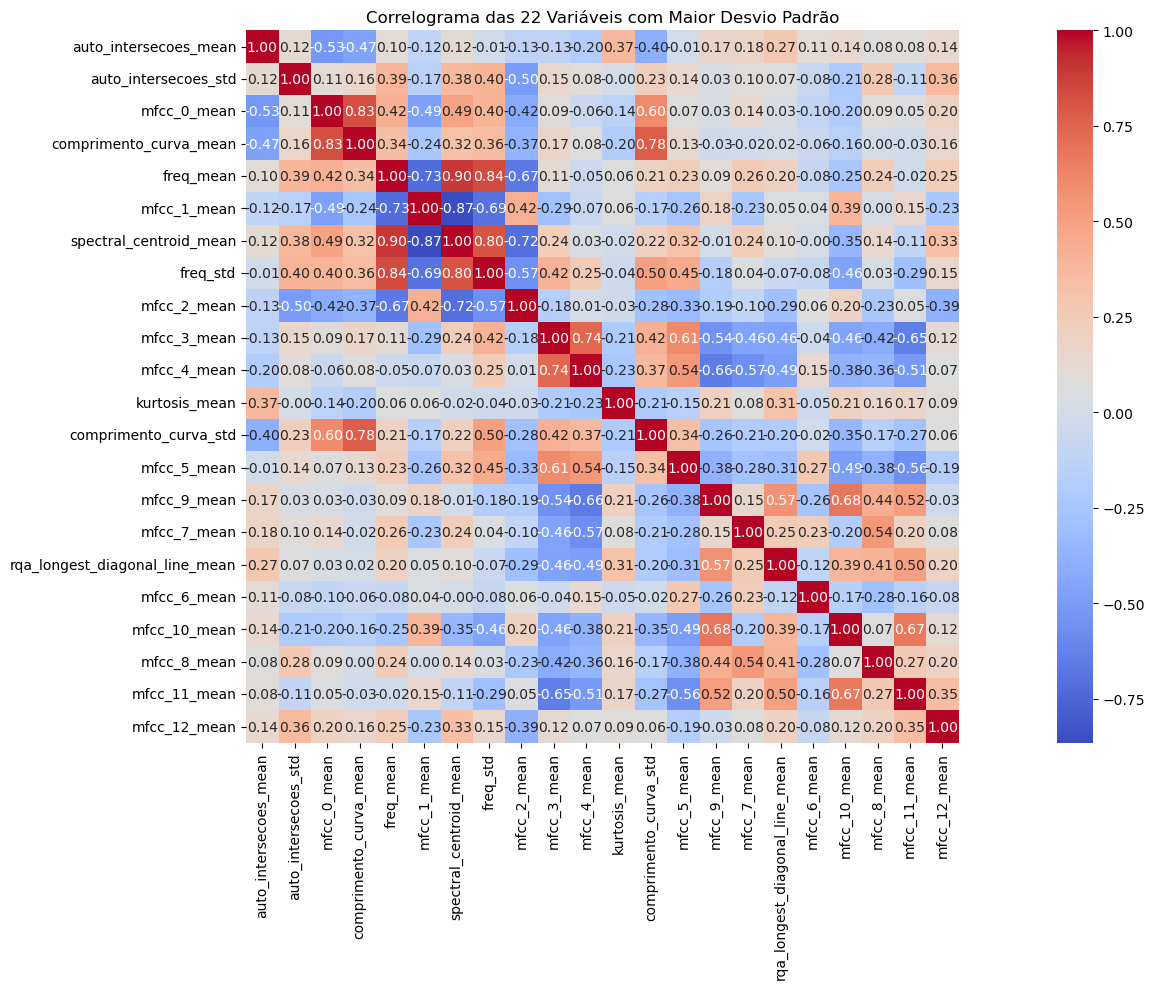

In [25]:
desc = df_agg_cod.describe().T.sort_values("std", ascending=False)
top_vars = desc.head(22).index.tolist()
corr = df_agg_cod[top_vars].corr()


plt.figure(figsize=(20, 10))

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)

plt.title("Correlograma das 22 Variáveis com Maior Desvio Padrão")

plt.tight_layout()

plt.show()

O Heatmap de correlação de Pearson entre as 22 variáveis com maior desvio padrão do dataset agregado por janela nos diz que há alta correlação (redundância potencial) entre:

* `mfcc_0_mean`:
     * `comprimento_curva_mean` (r=0.83)
     * `comprimento_curva_std` (r=0.61)

* `freq_mean`:
     * `freq_std` (r=0.77)
     * `spectral_centroid_mean` (r=0.92)

* `mfcc_3_mean`:
     * `mfcc_4_mean` (r=0.70)

* `mfcc_9_mean`:
     * `mfcc_10_mean` (r=0.65)


DECISÃO PROVISÓRIA: 
- deletar as _features_ de maior correlação com outras:


In [ ]:
"""

- checar quantos anomalias por paciente
- medias de frequencias dominantes devem virar atributo, CASO não façamos classificaçao binaria
com Normal e Sopro

"""

In [26]:
df_agg_cod = df_agg_cod.drop(
    columns=['freq_mean', 'comprimento_curva_mean', 'has_trapping_mean', 'freq_std'], errors='ignore')
desc = df_agg_cod.describe().T.sort_values("std", ascending=False)

In [27]:
# Como Gender_M e Gender_F são inversamente correlacionados, é interessante deletar um desses atributos
del df_agg_cod['Gender_M']

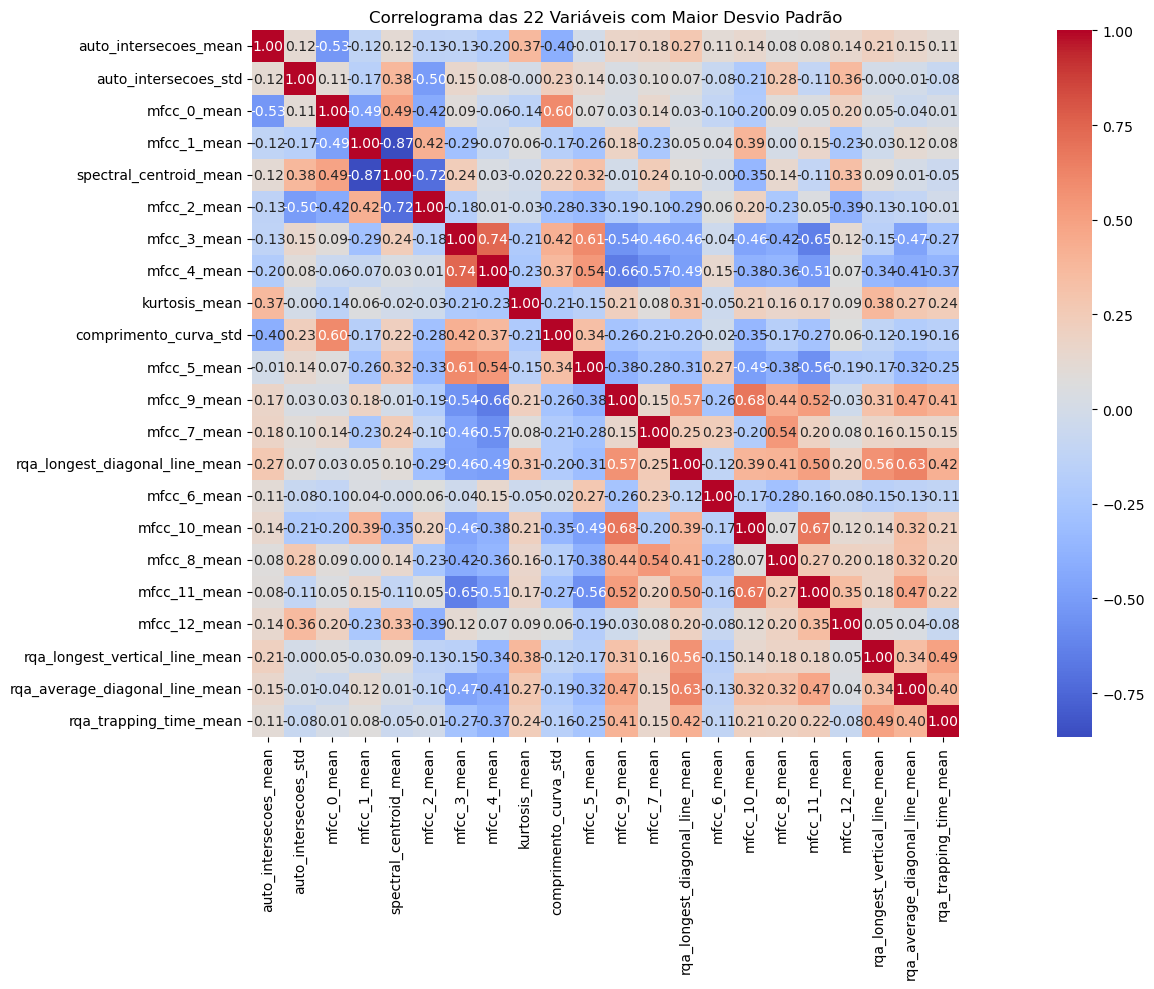

In [28]:
top_vars = desc.head(22).index.tolist()
corr = df_agg_cod[top_vars].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlograma das 22 Variáveis com Maior Desvio Padrão")
plt.tight_layout()
plt.show()

In [105]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # Copiar base
# df_features = df_agg_cod.copy()

# # Identificar MFCCs
# mfcc_cols = [
#     col for col in df_features.columns if "mfcc_" in col and "_mean" in col]

# # OUTRA FEATURES: manter apenas colunas numéricas úteis (sem redundâncias e constantes)
# non_mfcc_cols = [
#     col for col in df_features.select_dtypes(include=["float64", "int"]).columns
#     if col not in mfcc_cols + ["window_id"] and not col.endswith("_std")
# ]

# # X_A: versão com MFCCs selecionados manualmente (os menos correlacionados)
# mfcc_selected = ["mfcc_0_mean", "mfcc_3_mean", "mfcc_9_mean"]
# X_A = df_features[mfcc_selected + non_mfcc_cols].copy()

# # X_B: versão com PCA nos MFCCs (3 componentes)
# scaler = StandardScaler()
# X_mfcc_scaled = scaler.fit_transform(df_features[mfcc_cols])
# pca = PCA(n_components=3)
# X_mfcc_pca = pca.fit_transform(X_mfcc_scaled)

# # Nomear colunas PCA
# df_pca_mfcc = pd.DataFrame(
#     X_mfcc_pca, columns=["mfcc_pca_1", "mfcc_pca_2", "mfcc_pca_3"])
# df_pca_mfcc.index = df_features.index  # garantir alinhamento

# X_B = pd.concat([df_pca_mfcc, df_features[non_mfcc_cols]], axis=1)
# del X_B['has_trapping_mean']
# del X_B['freq_mean']


## 3. ANOVA entre classes (usando argmax da codificação one-hot como label)

ANOVA - Analysis of Variance

Um teste estatístico que responde à pergunta:

“Essa variável é diferente entre os grupos (classes) ou não?”

In [29]:
from scipy.stats import f_oneway

anova_binaria = {}

y = df_agg_cod["Heart_Sound_Type_Normal"] 

for var in top_vars:
    grupo_normal = df_agg_cod[df_agg_cod["Heart_Sound_Type_Normal"] == 1][var].dropna(
    )
    grupo_anormal = df_agg_cod[df_agg_cod["Heart_Sound_Type_Normal"]
                       == 0][var].dropna()

    if len(grupo_normal) >= 2 and len(grupo_anormal) >= 2:
        try:
            pval = f_oneway(grupo_normal, grupo_anormal).pvalue
            anova_binaria[var] = pval
        except Exception as e:
            print(f"Erro com {var}: {e}")
    else:
        print(f"Variável ignorada: {var} (amostras insuficientes)")

# Ordena por p-valor (menor = mais discriminativo)
anova_binaria_sorted = dict(sorted(anova_binaria.items(), key=lambda x: x[1]))

In [24]:
anova_binaria_sorted

{'mfcc_2_mean': np.float64(1.3192790481593503e-24),
 'spectral_centroid_mean': np.float64(1.2203737239914322e-18),
 'mfcc_5_mean': np.float64(1.2419205367622924e-15),
 'mfcc_6_mean': np.float64(6.089815692945334e-13),
 'mfcc_11_mean': np.float64(4.330972674444162e-12),
 'mfcc_9_mean': np.float64(8.899241052884677e-09),
 'mfcc_1_mean': np.float64(3.206930282059226e-07),
 'mfcc_0_mean': np.float64(4.877864528782453e-07),
 'mfcc_3_mean': np.float64(1.8670232229112506e-06),
 'mfcc_10_mean': np.float64(1.5905788284588508e-05),
 'mfcc_12_mean': np.float64(2.7547354347991083e-05),
 'auto_intersecoes_std': np.float64(0.0002354122954718829),
 'mfcc_4_mean': np.float64(0.00608050371796057),
 'rqa_average_diagonal_line_mean': np.float64(0.006743304975760878),
 'comprimento_curva_std': np.float64(0.02091895878532334),
 'mfcc_8_mean': np.float64(0.026317541094915256),
 'kurtosis_mean': np.float64(0.04233708265000768),
 'mfcc_7_mean': np.float64(0.18841902947334863),
 'auto_intersecoes_mean': np.flo

In [25]:
del df_agg_cod['window_id']

p-valores extremamente baixos indicam que essas variáveis são **altamente relevantes para diferenciar entre classes** de sons cardíacos. Variáveis como MFCCs, auto-interseções e métricas RQA se destacam como mais informativas.

## 4. UMAP e t-SNE para separação não linear


- O StandardScaler é aplicado para normalizar os dados antes da redução dimensional.

- Um PCA inicial com 30 componentes foi utilizado antes do t-SNE para reduzir ruído e acelerar o processo.

- O t-SNE foi aplicado com:

     - `n_components=2`: projetando os dados para duas dimensões.

     - `perplexity=30`: define o tamanho do “contexto” considerado localmente em torno de cada ponto (ajuste fino de agrupamentos).

t-SNE sem PCA pode se perder em ruído. PCA --> t-SNE é uma estratégia clássica para manter estrutura relevante e reduzir overfitting visual.

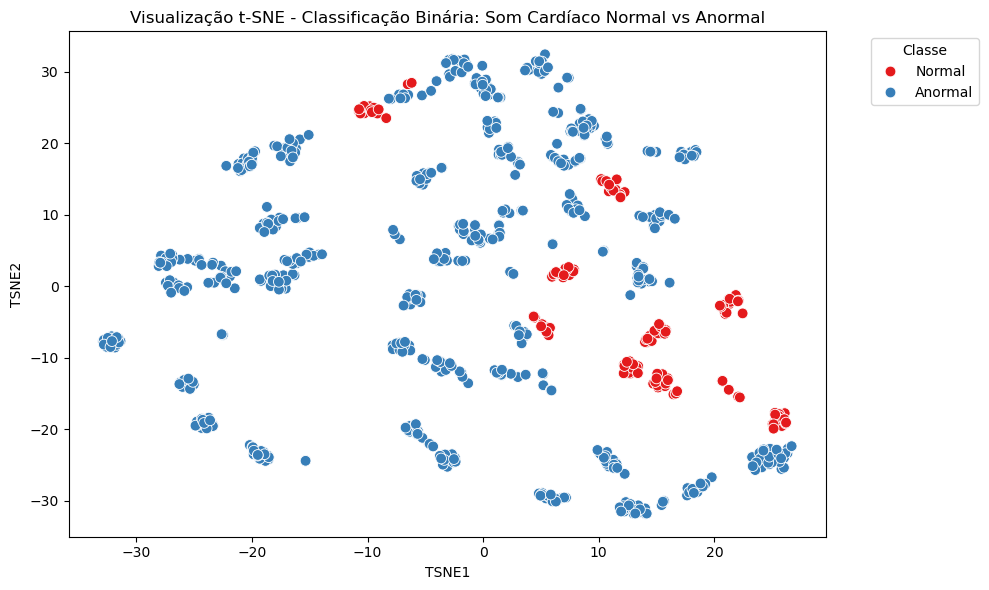

In [ ]:

df = df_agg_cod.copy()

X = df.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id"], errors="ignore")

if "Heart_Sound_Type_Normal" in df.columns:
    df["label"] = df["Heart_Sound_Type_Normal"].map(
        {0: "Anormal", 1: "Normal"})
    y = df["label"]
else:
    raise ValueError("Coluna 'Heart_Sound_Type_Normal' não encontrada.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Redução de dimensionalidade com PCA antes do t-SNE
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

df["TSNE1"] = X_tsne[:, 0]
df["TSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2",
                hue="label", palette="Set1", s=60)
plt.title(
    "Visualização t-SNE - Classificação Binária: Som Cardíaco Normal vs Anormal")
plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Importância das variáveis (com _RandomForest_)


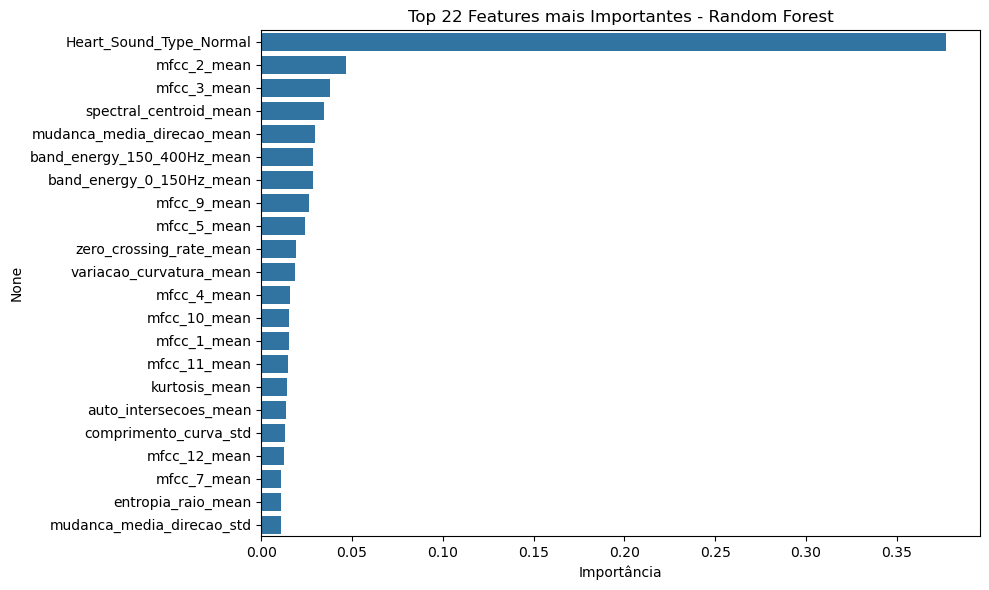

(Heart_Sound_Type_Normal       0.376936
 mfcc_2_mean                   0.046813
 mfcc_3_mean                   0.037787
 spectral_centroid_mean        0.034435
 mudanca_media_direcao_mean    0.029812
 band_energy_150_400Hz_mean    0.028557
 band_energy_0_150Hz_mean      0.028509
 mfcc_9_mean                   0.026265
 mfcc_5_mean                   0.024228
 zero_crossing_rate_mean       0.019437
 variacao_curvatura_mean       0.018848
 mfcc_4_mean                   0.015817
 mfcc_10_mean                  0.015329
 mfcc_1_mean                   0.015212
 mfcc_11_mean                  0.014969
 kurtosis_mean                 0.014463
 auto_intersecoes_mean         0.013810
 comprimento_curva_std         0.013305
 mfcc_12_mean                  0.012612
 mfcc_7_mean                   0.011152
 entropia_raio_mean            0.010884
 mudanca_media_direcao_std     0.010785
 dtype: float64,
 {'mfcc_2_mean': np.float64(1.3192790481593503e-24),
  'spectral_centroid_mean': np.float64(1.220373723

In [28]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False).head(22)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted.values, y=importances_sorted.index)
plt.title("Top 22 Features mais Importantes - Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

importances_sorted, anova_binaria_sorted

O modelo Random Forest foi treinado sobre os dados normalizados (X_scaled) e as classes (y).

A importância de cada variável foi calculada com base na capacidade de redução de impureza (Gini) em cada árvore da floresta.

O gráfico de barras mostra as 22 variáveis mais importantes, com destaque para:

- Variáveis categóricas one-hot dos rótulos (Heart Sound Type_X), o que é esperado, pois elas são as verdadeiras classes (e estão sendo tratadas como features — aqui pode haver um erro conceitual, se elas estavam de fato na matriz X).

- Depois, aparecem variáveis do tipo:

     - mfcc_9_mean, mfcc_12_mean, mfcc_4_mean etc.

     - band_energy_150_400Hz_mean

     - spectral_centroid_mean

     - sample_entropy_mean

Essas coincidem com os resultados da ANOVA realizada anteriormente, o que valida sua importância estatística e empírica.



## 6. Separação Não-Linear: PCA e t-SNE

O PCA (Principal Component Analysis) reduz a dimensionalidade do dataset projetando os dados em componentes principais que preservam a **variância máxima**. É útil para visualizar a estrutura global dos dados. O t-SNE (t-distributed Stochastic Neighbor Embedding) é uma técnica não-linear que foca em preservar **relações locais** entre os pontos. É mais adequado quando queremos identificar **aglomerados ou separações sutis** entre as classes.



In [13]:
numeric_cols = df_agg_cod.select_dtypes(
    include=["float64", "int"]).columns.drop("window_id", errors="ignore")

X_scaled = StandardScaler().fit_transform(df_agg_cod[numeric_cols])
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

df_plot = df_agg_cod.copy()
df_plot["pca_1"] = X_pca[:, 0]
df_plot["pca_2"] = X_pca[:, 1]
df_plot["pca_3"] = X_pca[:, 2]

fig = px.scatter_3d(
    df_plot,
    x="pca_1",
    y="pca_2",
    z="pca_3",
    color="label",
    opacity=0.8,
    title="Separação das classes via PCA (3D)"
)
fig.show()

No gráfico 3D gerado pelo PCA, observamos uma **boa separação** para algumas classes como:

- **AV Block** (bloco AV)
- **Tachycardia**
- **S3, S4**  
- **Murmúrios Sistólicos**

Classes como **Normal**, **S3** e **S4** apresentaram dispersões que ainda permitem certa separação espacial entre si.


In [14]:
# t-SNE

df = df_agg_cod.copy()

label_col = [c for c in df.columns if c.startswith("Heart Sound Type_")]
df["label"] = df[label_col].idxmax(axis=1)

# Separar features numéricas
X = df.select_dtypes(include="number").drop(
    columns=["window_id"], errors="ignore")
X = X.drop(columns=label_col, errors="ignore")

# Normalização
X_scaled = StandardScaler().fit_transform(X)

# t-SNE em 3D
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

df["tsne_1"] = X_tsne[:, 0]
df["tsne_2"] = X_tsne[:, 1]
df["tsne_3"] = X_tsne[:, 2]

fig = px.scatter_3d(df, x="tsne_1", y="tsne_2", z="tsne_3", color="label",
                    title="t-SNE (3D) - Separação por tipo de som cardíaco",
                    opacity=0.8)
fig.show()

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



O t-SNE confirmou os agrupamentos observados no PCA, com separações ainda mais acentuadas para:

- **AV Block**
- **Tachycardia**
- **Late Diastolic Murmur**
- **Normal**
- **S3 / S4** em regiões parcialmente isoladas

Esses resultados sugerem **forte potencial separativo** entre várias classes mesmo com um dataset relativamente pequeno.


## 7. ViolinPlots dos top 5 MFCCs entre 2-3 classes mais distintas

In [15]:
df.columns

Index(['window_id', 'centro_x_mean', 'centro_y_mean', 'raio_medio_mean',
       'raio_std_mean', 'raio_max_mean', 'raio_min_mean', 'simetria_x_mean',
       'simetria_y_mean', 'densidade_nucleo_mean', 'variacao_curvatura_mean',
       'mudanca_media_direcao_mean', 'entropia_raio_mean',
       'auto_intersecoes_mean', 'mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'rqa_recurrence_rate_mean',
       'rqa_determinism_mean', 'rqa_average_diagonal_line_mean',
       'rqa_longest_diagonal_line_mean', 'rqa_entropy_diagonal_lines_mean',
       'rqa_laminarity_mean', 'rqa_trapping_time_mean',
       'rqa_longest_vertical_line_mean', 'rqa_entropy_vertical_lines_mean',
       'rqa_rqa_threshold_mean', 'rms_energy_mean', 'spectral_entropy_mean',
       'band_energy_0_150Hz_mean', 'band_energy_150_400Hz_mean',
       'sample_entr

D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

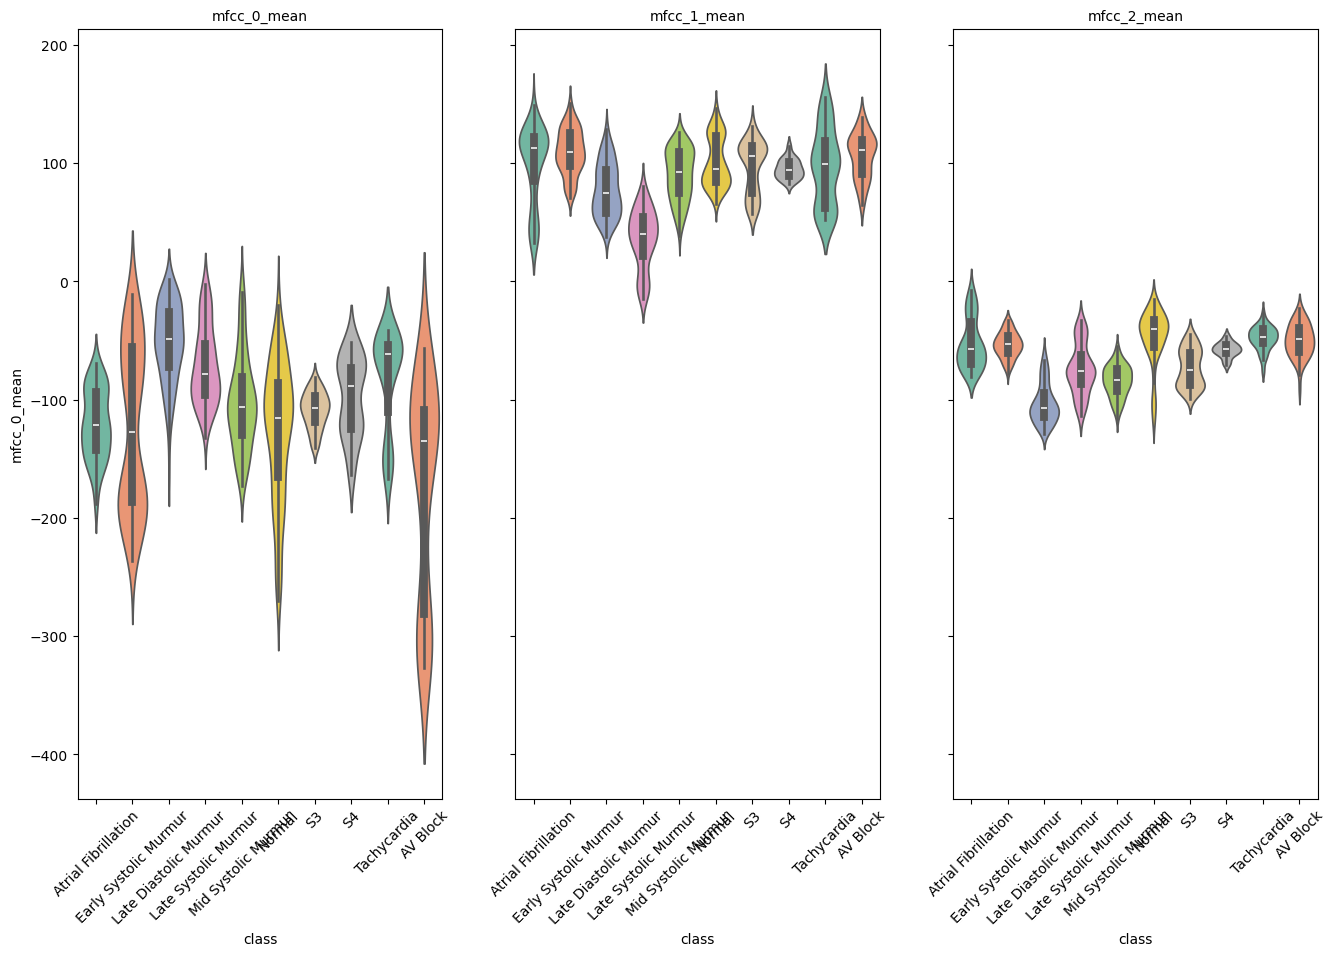

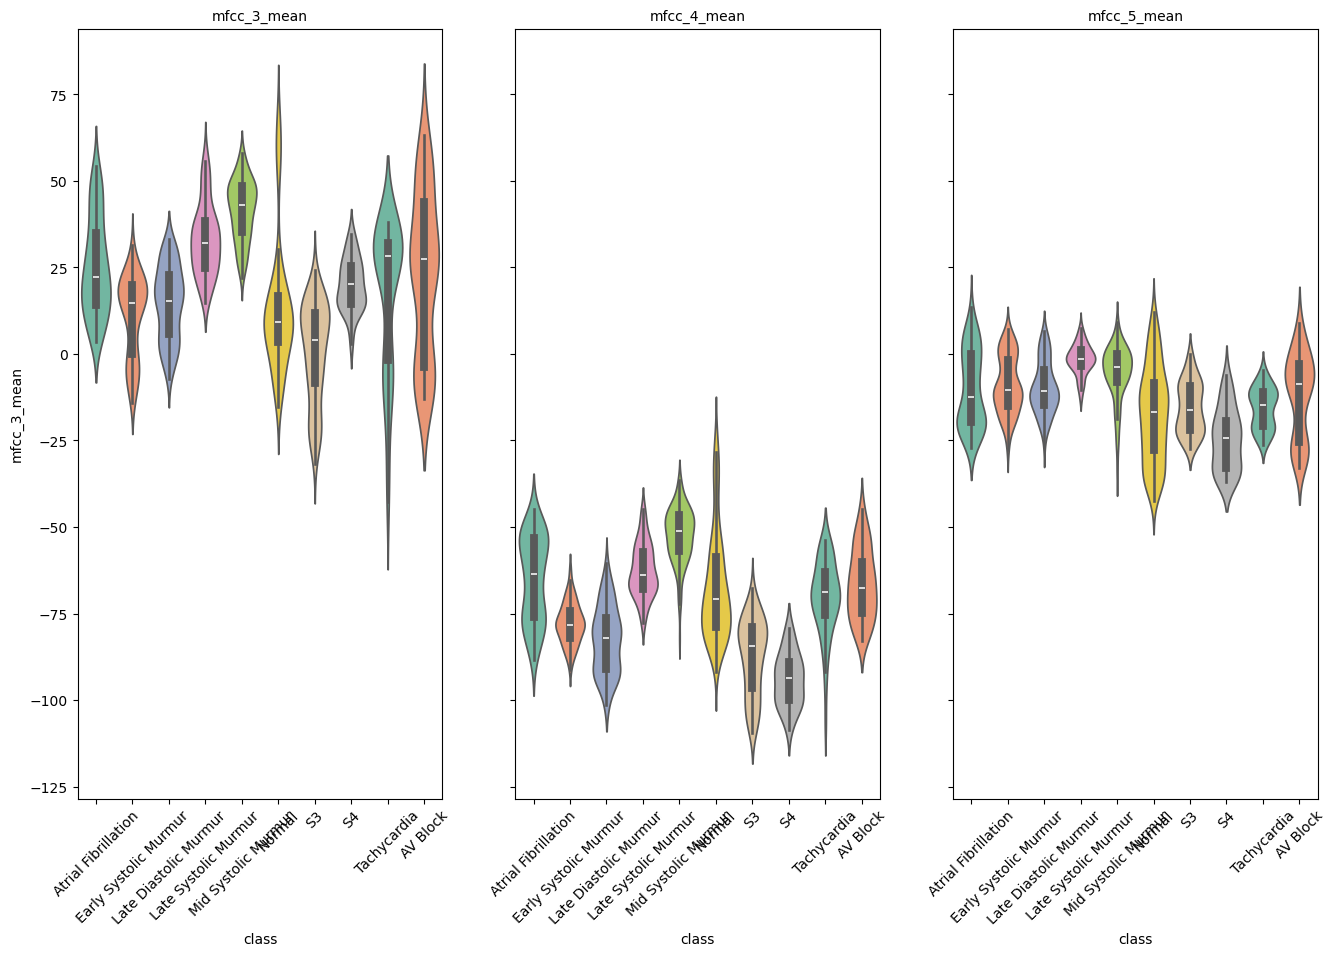

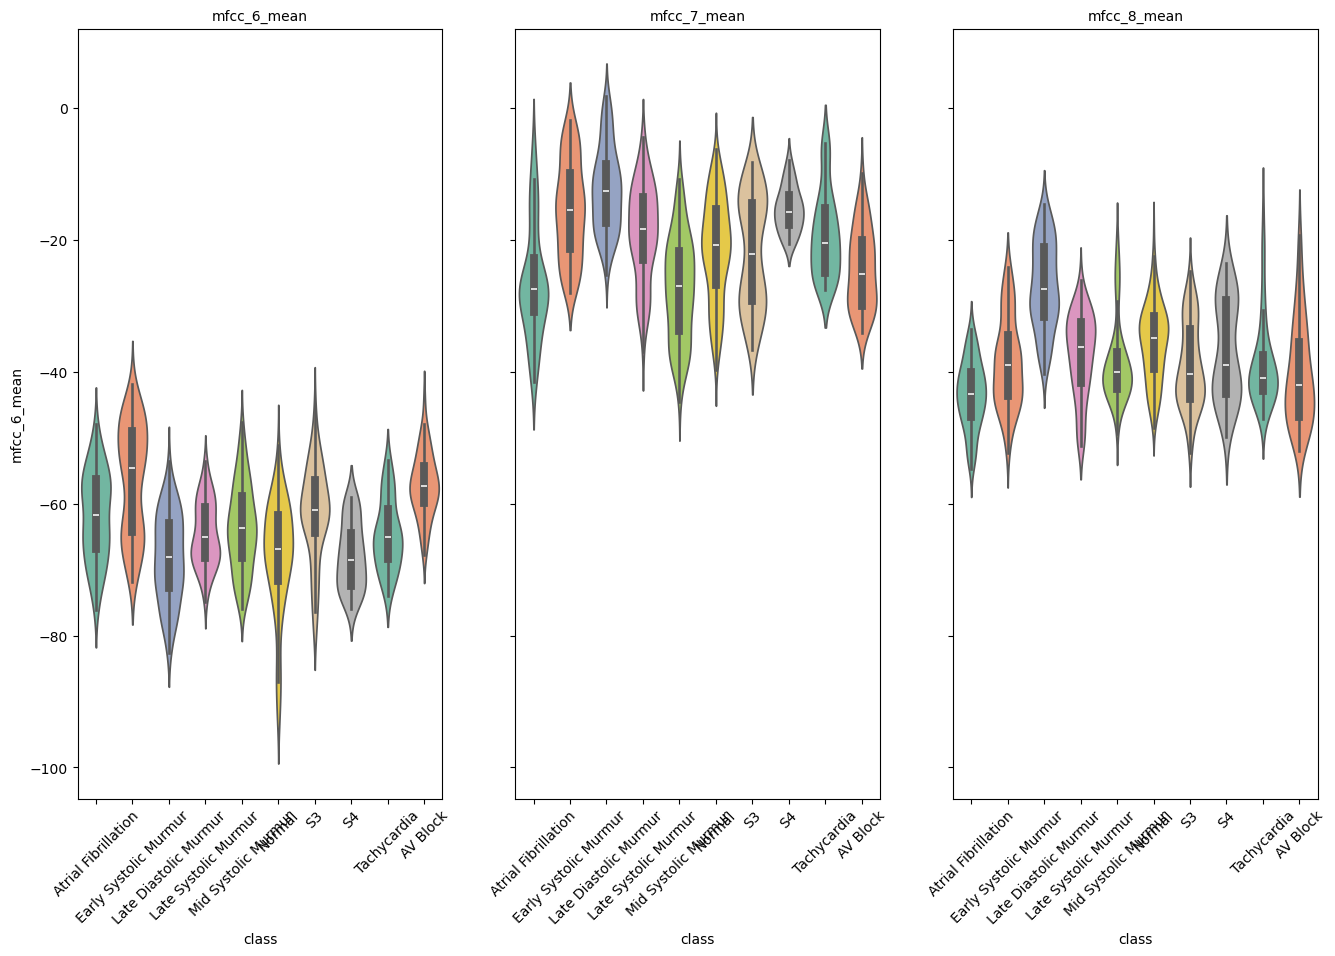

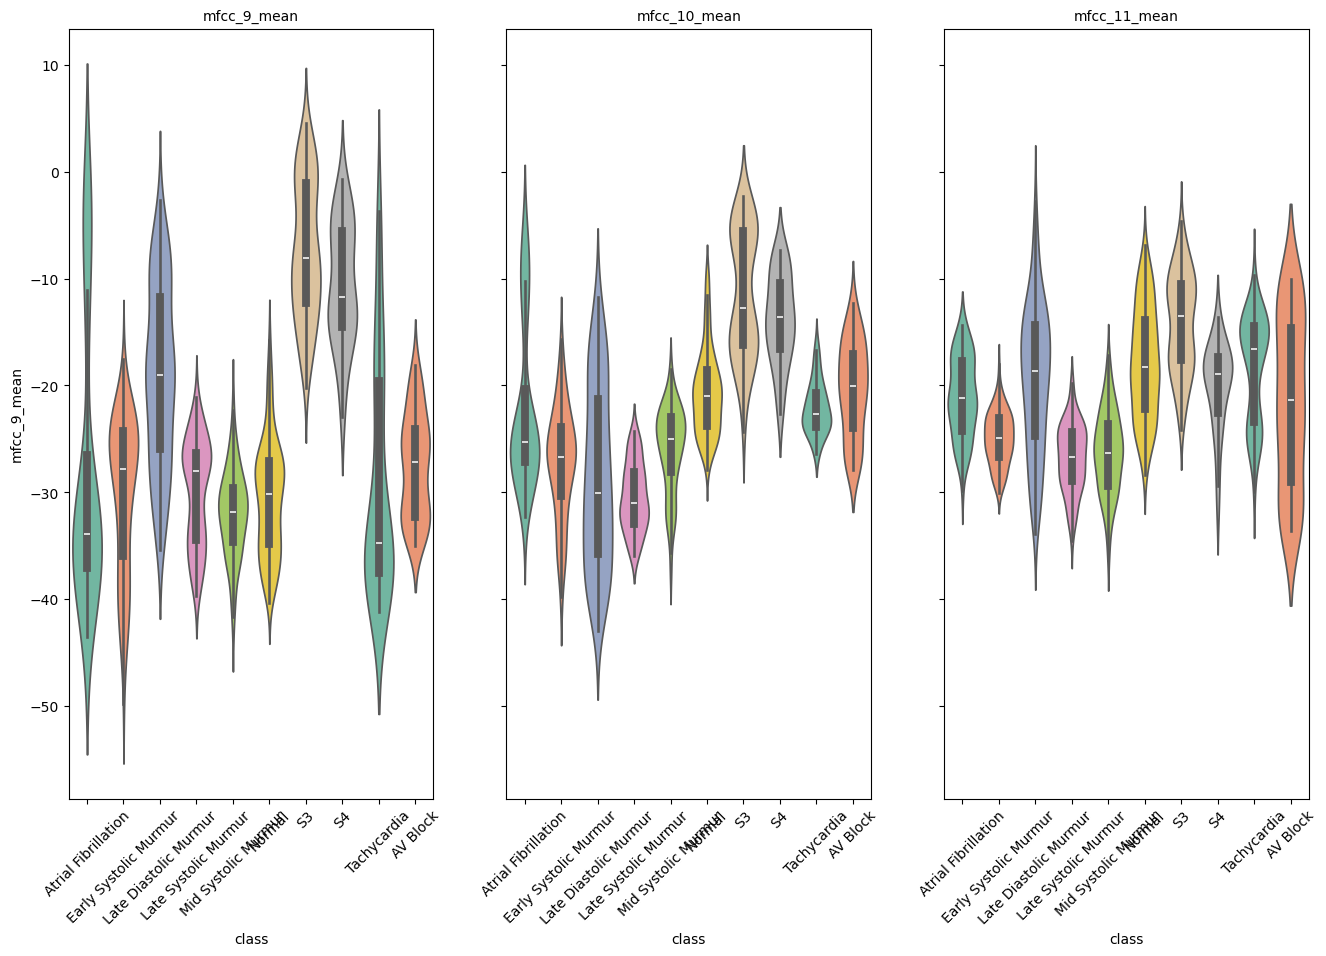

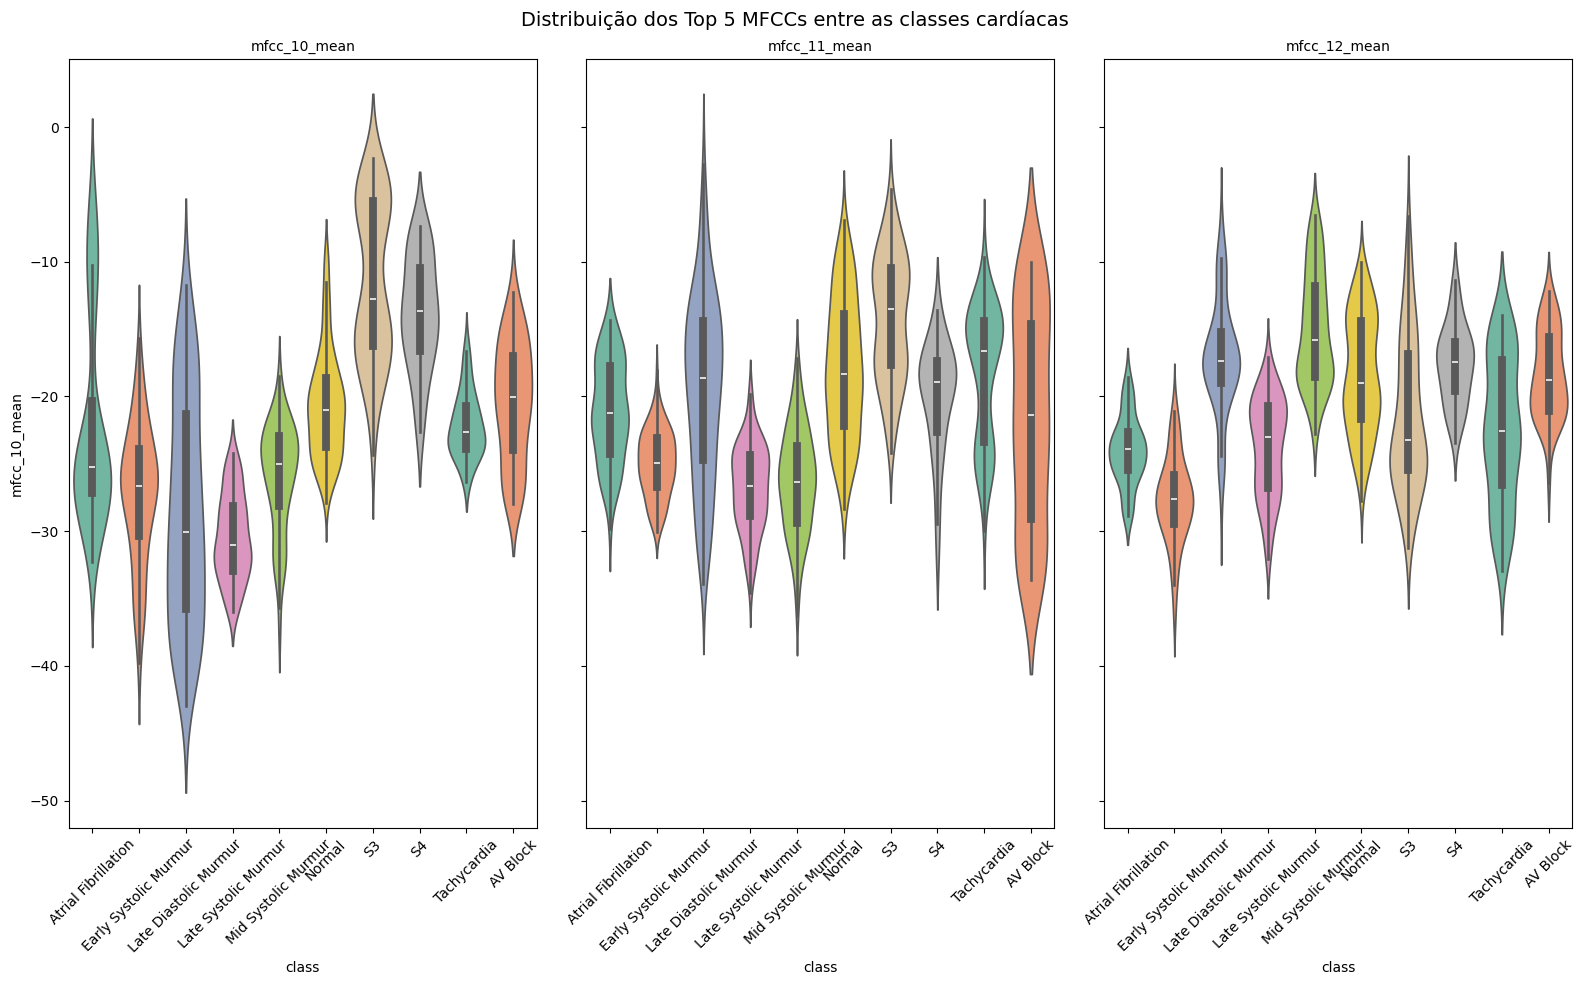

In [48]:

# Selecionar os top 5 MFCCs com base nos resultados de ANOVA anteriores
top_mfccs = ['mfcc_0_mean', 'mfcc_1_mean',
              'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
              'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean',
              'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
              'mfcc_11_mean', 'mfcc_12_mean']

# Nome da coluna de rótulo de classe
label_col = 'Heart Sound Type'  # nome comum antes da codificação one-hot

# Extração do nome da classe com one-hot encoding reversa
df['class'] = df.filter(like='Heart Sound Type_').idxmax(
    axis=1).str.replace('Heart Sound Type_', '')

# Plotar violinplots dos MFCCs

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[:3]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[3:6]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[6:9]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[9:12]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[10:]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)


# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)
# for i, mfcc in enumerate(top_mfccs[9:12]):
#     sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],)
#     axs[i].set_title(mfcc, fontsize=10)
#     axs[i].tick_params(axis='x', rotation=45)


fig.suptitle(
    'Distribuição dos Top 5 MFCCs entre as classes cardíacas', fontsize=14)
plt.tight_layout()
plt.show()

D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

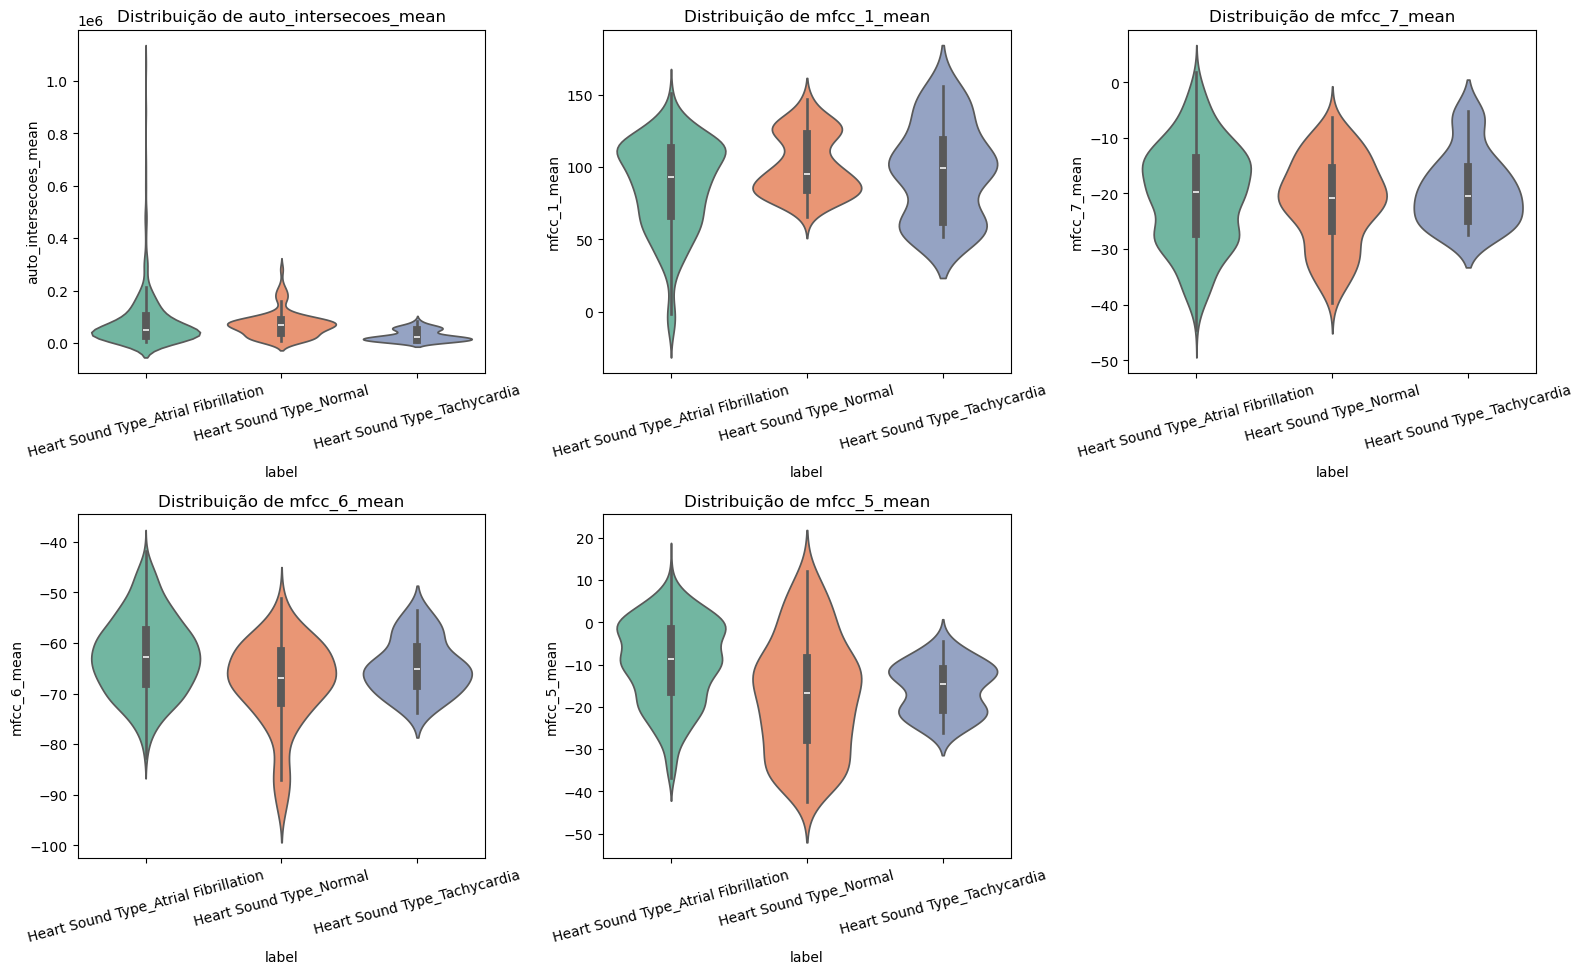

In [ ]:

df = df_agg_cod.copy()

# Determinar os top 5 MFCCs a partir dos resultados do ANOVA
top_mfccs = ['mfcc_3_mean', 'mfcc_1_mean',
             'mfcc_7_mean', 'mfcc_6_mean', 'mfcc_5_mean']

# Selecionar apenas classes de interesse (AFib, Normal, e uma terceira distinta)
classes_selecionadas = [
    'Heart Sound Type_Atrial Fibrillation',
    'Heart Sound Type_Normal',
    'Heart Sound Type_Tachycardia'
]

# Adicionar coluna de rótulo unificado
df["label"] = df[classes_selecionadas].idxmax(axis=1)

# Gerar os violinplots
plt.figure(figsize=(16, 10))
for i, col in enumerate(top_mfccs, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(data=df, x="label", y=col, palette="Set2")
    plt.title(f"Distribuição de {col}")
    plt.xticks(rotation=15)

plt.tight_layout()
plt.show()